\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

Fraction of successes, as calculated below, is 11.78%. 

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X = pd.read_csv('marketing.csv')
X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing', 'loan'])
y = np.where(X.pop('y')=='yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
y_train.sum()/len(y_train)

0.11782377603908752

## (b) {-}

Here we train a logistic regression model, serialize the trained model and save it locally to prevent retraining. 

In [2]:
from sklearn.linear_model import LogisticRegression
import pickle

clf = LogisticRegression(penalty='none').fit(X_train, y_train)

with open('clf.pkl', 'wb') as f:
    pickle.dump(clf, f)

with open('clf.pkl', 'rb') as f:
    clf = pickle.load(f)

The misclassification rate calculated below is 11.55%. 

In [2]:
from sklearn.metrics import accuracy_score
import pickle

with open('clf.pkl', 'rb') as f:
    clf = pickle.load(f)
    
y_pred = clf.predict(X_test)
1 - accuracy_score(y_test, y_pred)

0.11548257372654158

## (c) {-}

A classifier to always say 'no' will have misclassification rate 11.53%, not much different from that of the logistic regression. 

In [3]:
y_pred = np.zeros_like(y_test)
1 - accuracy_score(y_test, y_pred)

0.11528150134048254

## (d) {-}

Only 11.53% out of all clients in the test data said yes. This is the sample proportion, also the MLE estimate of the fraction. If we randomly picked 1000 client to call, this is the fraction we can expect to say 'yes'. 

Selecting the first 1000 clients who have the largest probabilities to say 'yes' according to the logistic regression, the fraction increases to 29.1% (more than doubled). 

In [4]:
predict_proba_test = clf.predict_proba(X_test)[:, 1]
bestIdxSet = predict_proba_test.argsort()[-1000:]

y_select = y_test[bestIdxSet]

print('Fraction of clients who say yes from random selection: ', y_test.sum()/len(y_test))
print('Fraction of clients who say yes from logistic regression: ', y_select.sum()/len(y_select))

Fraction of clients who say yes from random selection:  0.11528150134048257
Fraction of clients who say yes from logistic regression:  0.291


## (e) {-}

Below is a the ROC curve plot and a convenient ```plot_roc``` function for later reuse. 

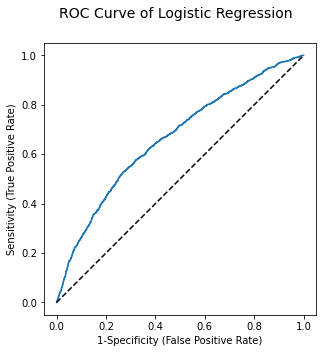

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import roc_curve
from pandas import DataFrame

fpr, tpr, _ = roc_curve(y_test, predict_proba_test) 

def plot_roc(spec, sens):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    fig.suptitle('ROC Curve of Logistic Regression', fontsize=14)
    ax.plot(1-spec, sens)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set( aspect=1, 
            xlabel='1-Specificity (False Positive Rate)', 
            ylabel='Sensitivity (True Positive Rate)')
    return ax
    
plot_roc(1-fpr, tpr)
plt.show()

# 2. {-}

## (a) {-}

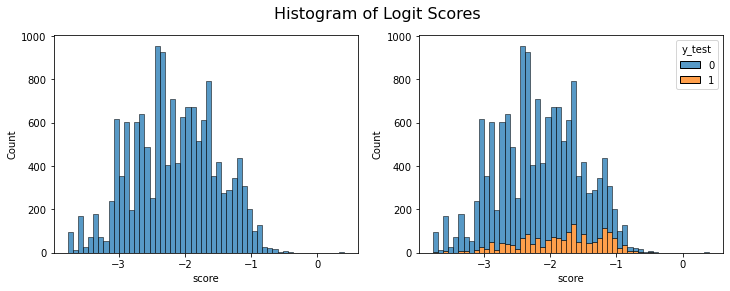

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

pn, pp = clf.predict_proba(X_test).T
scores = np.log(pp/pn)

df = DataFrame({'score': scores, 'y_test': y_test})

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(scores, ax=ax[0])
sns.histplot(x='score', hue='y_test', data=df, multiple='stack', ax=ax[1])
ax[0].set(xlabel='score')
plt.suptitle('Histogram of Logit Scores', fontsize=16)
plt.show()

## (b) {-}

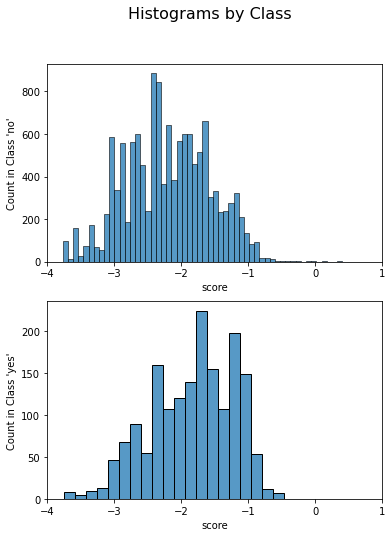

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sns.histplot(x='score', data=df[df['y_test']==0], ax=ax[0])
sns.histplot(x='score', data=df[df['y_test']==1], ax=ax[1])
ax[0].set(xlim=(-4, 1), ylabel="Count in Class 'no'")
ax[1].set(xlim=(-4, 1), ylabel="Count in Class 'yes'")
plt.suptitle('Histograms by Class', fontsize=16)
plt.show()

## (c) {-}

\begin{align*}
TPR(T)  &= \mathbb P(\text{score} > T ~|~ \text{class 'yes'}) = \int_T^\infty f_1(x)\,dx, \\
FPR(T)  &= 1 - \text{specificity} \\
        &= 1 - \mathbb P(\text{score} < T ~|~ \text{class 'no'}) \\
        &= 1 - \mathbb P(\text{score} > T ~|~ \text{class 'no'}) \\
        &= \int_T^\infty f_0(x)\,dx.
\end{align*}

$TPR$ corresponds to the blue area on the right of the vertical line on the class 'yes' histogram, while
$FPR$ corresponds to the blue area on the right of the vertical line on the class 'no' histogram. 

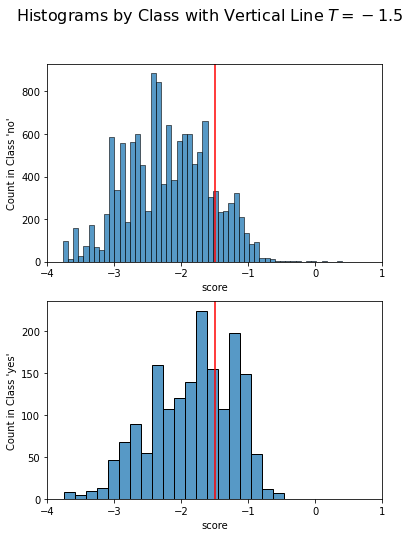

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sns.histplot(x='score', data=df[df['y_test']==0], ax=ax[0])
sns.histplot(x='score', data=df[df['y_test']==1], ax=ax[1])
ax[0].set(xlim=(-4, 1), ylabel="Count in Class 'no'")
ax[1].set(xlim=(-4, 1), ylabel="Count in Class 'yes'")
ax[0].axvline(x=-1.5, color='r')
ax[1].axvline(x=-1.5, color='r')
plt.suptitle('Histograms by Class with Vertical Line $T=-1.5$', fontsize=16)
plt.show()

## (d) {-}

Plug in $f(t) = FPR(t)$, $g(t) = TPR(t)$, $t_0=\infty$, $t_f = -\infty$ to get
\begin{align*}
AUC &= \int_{t_0}^{t_f} g(t) f^\prime(t)\,dt  \\
    &= \int_{\infty}^{-\infty} TPR(t) FPR^\prime(t)\,dt.
\end{align*}

## (e) {-}

Note that
\begin{align*}
FPR^\prime(T) = \frac{d}{dT}\int^\infty_Tf_0(x)\,dx = -f_0(T).
\end{align*}
Plug this into the above $AUC$ integral to get 
\begin{align*}
AUC &= \int_{\infty}^{-\infty} \left(\int_T^\infty f_1(x)\,dx\right) (-f_0(T))\,dT \\
&= \int_{-\infty}^{\infty} \int_T^\infty f_0(T)f_1(x)\,dx\,dT.
\end{align*}
Assuming that $S_1$ and $S_2$ are independent, $f_0(T)f_1(x)$ is simply their joint distribution, so this integral is the probability of $(S_1, S_2)$ being in the region $\{(x, T)\in \mathbb R^2 ~|~ -\infty < T < \infty, T < x < \infty\} = \{(x, T)\in \mathbb R^2 ~|~ T < x\}$, which is equivalent to the $\mathbb P(S_1 > S_0)$. Thus we conclude 
\begin{align*}
AUC = \mathbb P(S_1 > S_0). 
\end{align*}
Below is a plot of the domain of integration. 

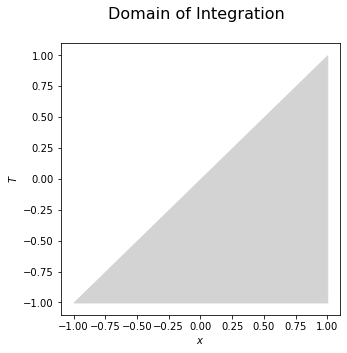

In [9]:
import matplotlib.pyplot as plt
from pandas import DataFrame

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x = [-1, 1]
y = [-1, 1]
ax.fill_between(x, -1, y, color='lightgray')
ax.set(xlabel='$x$', ylabel='$T$')
plt.suptitle('Domain of Integration', fontsize=16)
plt.show()

# 3. {-}

## (a) {-}

```scores``` defined in 2(a)

In [10]:
import numpy as np

threshold = -1

def eval_estimate(estimate, truth, loss_FP=5, loss_FN=100):
    tp = (truth & estimate).sum()
    fp = ((1-truth) & estimate).sum()
    fn = (truth & (1-estimate)).sum()
    tn = ((1-truth) & (1-estimate)).sum()

    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    loss = fp*loss_FP + fn*loss_FN
    
    return (sens, spec, loss)

eval_estimate(scores > threshold, y_test)

(0.053488372093023255, 0.9808333333333333, 164065)

## (b) {-}

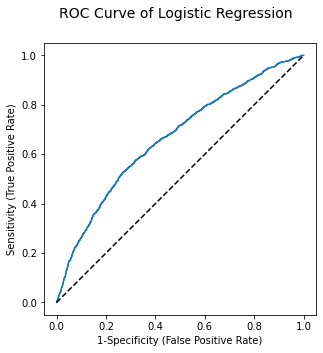

In [11]:
unique_logits = np.sort(np.unique(scores))
midpts = (unique_logits[1:] + unique_logits[:-1])/2
sens, spec, loss = np.vectorize(lambda threshold: eval_estimate(scores > threshold, np.array(y_test, dtype=bool)))(midpts)

plot_roc(spec, sens)
plt.show()

## (c) {-}

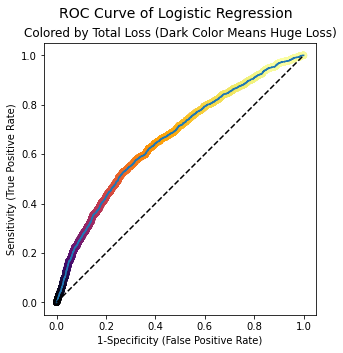

In [12]:
ax = plot_roc(spec, sens)
ax.scatter(1-spec, sens, c=-loss, cmap=cm.inferno)
ax.set(title='Colored by Total Loss (Dark Color Means Huge Loss)')
plt.show()

## (d) {-}

(what do you notice?)

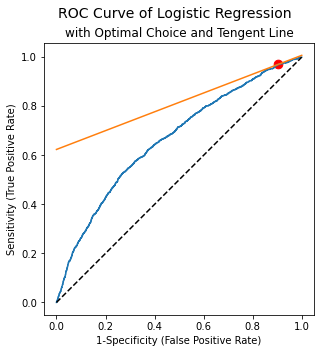

In [24]:
optimumIdx = np.argmin(loss)

x0 = 1-spec[optimumIdx]
y0 = sens[optimumIdx]

loss_FP = 5
loss_FN = 100
P = (y_test).sum()
N = (1 - y_test).sum()
slope = (N/P)*(loss_FP/loss_FN)
lineEq = lambda x: slope*(x-x0) + y0

ax = plot_roc(spec, sens)
ax.plot([0, 1], [lineEq(0), lineEq(1)])
ax.scatter([x0], [y0], color='red', s=75)
ax.set(title='with Optimal Choice and Tengent Line')
plt.show()

## (e) {-}

### i. {-}

Define $TN, FP, TP$ and $FN$ in the test set to be the number of true negative, false positive, true positive and false negative data points, respectively. Then we have 
\begin{align*}
FPR &= \frac{FP}{TN + FP}\\
FNR &= \frac{FN}{TP + FN}\\
N &= TN + FP \\
P &= TP + FN. \\
\end{align*}
Thus we know $FP = FPR\cdot N, FN = FNR\cdot P$ and the total loss is 
\begin{align*}
FP\cdot L_{FP} + FN\cdot L_{FN} = FPR\cdot N\cdot L_{FP} + FNR\cdot P\cdot L_{FN}. 
\end{align*}


### ii. {-}

In 2(c) we have established that $FPR(T) = \int_T^\infty f_0(x)\,dx$. In a similar manner, we can write 
\begin{align*}
FNR(T) = \mathbb P(\text{score} < T ~|~ \text{class 'yes'}) = \int_{-\infty}^T f_1(x)\,dx.
\end{align*}


### iii. {-}

Taking derivatives of 
\begin{align*}
FPR(T) = \int_T^\infty f_0(x)\,dx, \qquad FNR(T) = \int_{-\infty}^T f_1(x)\,dx, 
\end{align*}
we obtain $FPR^{\prime}(T) = -f_0(T), FNR^{\prime}(T) = f_1(T)$. 
Thus, the derivative of the total loss is 
\begin{align*}
FPR^{\prime}(T)\cdot N\cdot L_{FP} + FNR^{\prime}(T)\cdot P\cdot L_{FN} &= -f_0(T)\cdot N\cdot L_{FP} + f_1(T)\cdot P\cdot L_{FN}. 
\end{align*}
Set this to zero and isolate $f_1(T)/f_0(T)$ to obtain
\begin{align*}
\frac{f_1(T)}{f_0(T)} = \frac{N}{P} \cdot \frac{L_{FP}}{L_{FN}}. 
\end{align*}
This is the formula we used in 3(d). The proof is complete. 



Note: A parameteric form of the ROC curve is $(x(t), y(t)) = (FPR(t), TPR(t))$ so the slope of the tangent line is $dy/dx = (dy/dt)/(dx/dt) = TPR^{\prime}(t)/FPR^{\prime}(t) = f_1(t)/f_0(t)$. 


## (f) {-}

The optimal threshold on the true probability derived in the previous homework is $L_{FP}/(L_{FP} + L_{FN})$, which is $5/105 = 0.0476$ given our loss function here. We then apply the logit transformation to obtain the theoretical optimal threshold on the logit scores so that we can make use of the ```eval_estimate``` function implemented earlier. 

In [32]:
threshold_prob = 5/105
threshold_logit = np.log(threshold_prob/(1 - threshold_prob))

sensBestTrueProb, specBestTrueProb, lossBestTrueProb = eval_estimate(scores > threshold_logit, y_test)

print('Loss at theoretical optimal threshold: ', lossBestTrueProb)
print('Minimum loss found in 3(d):            ', np.min(loss))

Loss at theoretical optimal threshold:  65530
Minimum loss found in 3(d):             64695


## (g) {-}

reason for the differences? 

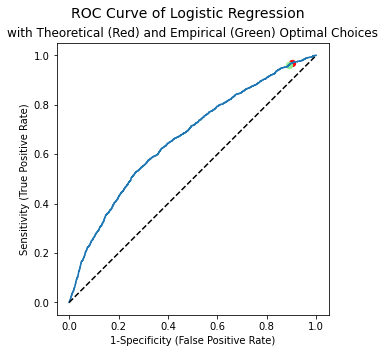

In [33]:
optimumIdx = np.argmin(loss)

x0 = 1-spec[optimumIdx]
y0 = sens[optimumIdx]

x1 = 1-specBestTrueProb
y1 = sensBestTrueProb

ax = plot_roc(spec, sens)
ax.scatter([x0], [y0], color='red', s=40)
ax.scatter([x1], [y1], color='lightgreen', s=40)
ax.set(title='with Theoretical (Red) and Empirical (Green) Optimal Choices')
plt.show()